# 70 Dog Breeds Classification
This training notebook covers training a classifier model to classify 70 different dog breeds.

The tech stack covered are:
* Pretrained ResNet 18 and EfficientNetB0
* Data Transformation
* Early Stopping
* Model saving and loading

The model is implemented in PyTorch

In [2]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    %pip3 install -U torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1
torchvision version: 0.14.1


In [2]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

In [6]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

Setup Device Agnostic

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Let's start with the dataset

The 70 dog breeds dataset is from Kaggle and can be found [here](https://www.kaggle.com/datasets/gpiosenka/70-dog-breedsimage-data-set?datasetId=453611)

In [5]:
from pathlib import Path

image_path = Path("data/")

# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/train'), WindowsPath('data/test'))

In [8]:
#Define some hyperparameters
args = {
    "batch_size": 64,
    "num_workers": 0,
    "num_classes": 70,
    "learning_rate": 0.001,
    "num_epochs": 10,
    "image_size": 224,
}

Turn dataset to dataloader

In [65]:
from utils.data_setup import create_dataloaders

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((args['image_size'], args['image_size'])),
    transforms.ToTensor(),
])

train_loader, test_loader , class_names = create_dataloaders(train_dir=train_dir,
                                                            test_dir=test_dir,
                                                            train_transform=manual_transforms,
                                                            test_transform=manual_transforms,
                                                            batch_size=args['batch_size'],
                                                            num_workers=args['num_workers'])

In [66]:
len(train_loader), len(test_loader)

(125, 11)

In [67]:
len(train_loader.dataset), len(test_loader.dataset)

(7946, 700)

We have a total of 7946 training samples and 700 testing samples, which is separated into 125 batchs and 11 batchs respectively

In [68]:
class_names

['Afghan',
 'African Wild Dog',
 'Airedale',
 'American Hairless',
 'American Spaniel',
 'Basenji',
 'Basset',
 'Beagle',
 'Bearded Collie',
 'Bermaise',
 'Bichon Frise',
 'Blenheim',
 'Bloodhound',
 'Bluetick',
 'Border Collie',
 'Borzoi',
 'Boston Terrier',
 'Boxer',
 'Bull Mastiff',
 'Bull Terrier',
 'Bulldog',
 'Cairn',
 'Chihuahua',
 'Chinese Crested',
 'Chow',
 'Clumber',
 'Cockapoo',
 'Cocker',
 'Collie',
 'Corgi',
 'Coyote',
 'Dalmation',
 'Dhole',
 'Dingo',
 'Doberman',
 'Elk Hound',
 'French Bulldog',
 'German Sheperd',
 'Golden Retriever',
 'Great Dane',
 'Great Perenees',
 'Greyhound',
 'Groenendael',
 'Irish Spaniel',
 'Irish Wolfhound',
 'Japanese Spaniel',
 'Komondor',
 'Labradoodle',
 'Labrador',
 'Lhasa',
 'Malinois',
 'Maltese',
 'Mex Hairless',
 'Newfoundland',
 'Pekinese',
 'Pit Bull',
 'Pomeranian',
 'Poodle',
 'Pug',
 'Rhodesian',
 'Rottweiler',
 'Saint Bernard',
 'Schnauzer',
 'Scotch Terrier',
 'Shar_Pei',
 'Shiba Inu',
 'Shih-Tzu',
 'Siberian Husky',
 'Vizsla',

## Visualize some data

torch.Size([3, 224, 224]) tensor(31)


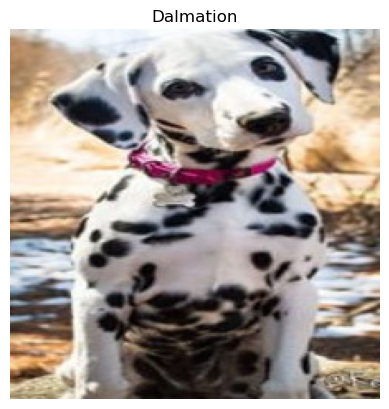

In [69]:
image, label = next(iter(train_loader))

image, label = image[0], label[0]

# Plot some images
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(image.shape, label)

We want to create the real dataloader, but let us inspect pretrained model

In [94]:
from utils.helper_functions import set_seeds

# pretrained ResNet18
resnet_weights =  torchvision.models.ResNet18_Weights.DEFAULT
resnet_auto_transform = resnet_weights.transforms()
resnet_auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

We will use augmentation for training dataset, but normal transformation for testing dataset

In [87]:
train_loader, test_loader , class_names = create_dataloaders(train_dir=train_dir,
                                                            test_dir=test_dir,
                                                            train_transform=resnet_auto_transform,
                                                            test_transform=resnet_auto_transform,
                                                            batch_size=args['batch_size'],
                                                            num_workers=args['num_workers'])

## Model Creation

In this notebook, I will experiment with pretrained ResNet18 and EffNetB0

We will create a feature extractor using ResNet18 and create custom classifier head.

In [88]:
model_0 = torchvision.models.resnet18(weights=resnet_weights).to(device)

for param in model_0.parameters():
    param.requires_grad = False

set_seeds(42)

# Add a new classifier
model_0.fc = nn.Sequential(
                        nn.Linear(in_features=model_0.fc.in_features, out_features=256),
                        nn.ReLU(),
                        nn.Dropout(0.4),
                        nn.Linear(256, args['num_classes'])).to(device)

In [89]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_0, 
        input_size=(32, 3, 224, 224), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 70]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

## Training Configuration

We will use Adam optimizer, with leraning rate of 1e-3

As for loss function, we will use CrossEntropyLoss with a 0.1 smoothing

Also, with early stopping

In [90]:
from utils import engine
from utils.early_stopback import EarlyStopback

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# create early stopper
early_stopper = EarlyStopback(patience=5, min_delta=0.05)

# Train the classifier head of the pretrained ResNet
set_seeds()
model_0_results = engine.train(model=model_0,
                               train_dataloader=train_loader,
                               test_dataloader=test_loader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=args['num_epochs'],
                               device=device,
                               early_stopback=early_stopper,
                               writer=None)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.6767 | train_acc: 0.4472 | test_loss: 1.3943 | test_acc: 0.8660
Epoch: 2 | train_loss: 1.6520 | train_acc: 0.7480 | test_loss: 1.2141 | test_acc: 0.9215
Epoch: 3 | train_loss: 1.5026 | train_acc: 0.8073 | test_loss: 1.1683 | test_acc: 0.9156
Epoch: 4 | train_loss: 1.4230 | train_acc: 0.8280 | test_loss: 1.1455 | test_acc: 0.9354
Epoch: 5 | train_loss: 1.3822 | train_acc: 0.8475 | test_loss: 1.1074 | test_acc: 0.9413
Epoch: 6 | train_loss: 1.3507 | train_acc: 0.8543 | test_loss: 1.0977 | test_acc: 0.9558
Epoch: 7 | train_loss: 1.3290 | train_acc: 0.8632 | test_loss: 1.1014 | test_acc: 0.9428
Epoch: 8 | train_loss: 1.2954 | train_acc: 0.8742 | test_loss: 1.0792 | test_acc: 0.9559
Epoch: 9 | train_loss: 1.2828 | train_acc: 0.8837 | test_loss: 1.0645 | test_acc: 0.9616
Epoch: 10 | train_loss: 1.2664 | train_acc: 0.8863 | test_loss: 1.0622 | test_acc: 0.9558


In [93]:
model_0_results

{'train_loss': [2.6767448692321776,
  1.6519979877471924,
  1.5025743980407715,
  1.4229706840515137,
  1.3822314701080323,
  1.3507292985916137,
  1.3289523096084594,
  1.2953532905578613,
  1.2827810487747193,
  1.2663982810974121],
 'train_acc': [0.44725,
  0.7479750000000001,
  0.8073250000000001,
  0.828025,
  0.847475,
  0.8543,
  0.8632000000000001,
  0.874225,
  0.8837,
  0.88635],
 'test_loss': [1.3942702250047163,
  1.2141397432847456,
  1.1682594906200061,
  1.1454676389694214,
  1.1073833162134343,
  1.0976854237643154,
  1.1014342741532759,
  1.079173369841142,
  1.0645150596445256,
  1.0622398094697432],
 'test_acc': [0.8660037878787878,
  0.9214962121212121,
  0.915625,
  0.9354166666666667,
  0.9412878787878788,
  0.9557765151515152,
  0.9428030303030304,
  0.9558712121212121,
  0.9615530303030302,
  0.9557765151515152]}

Let's visualize the performance

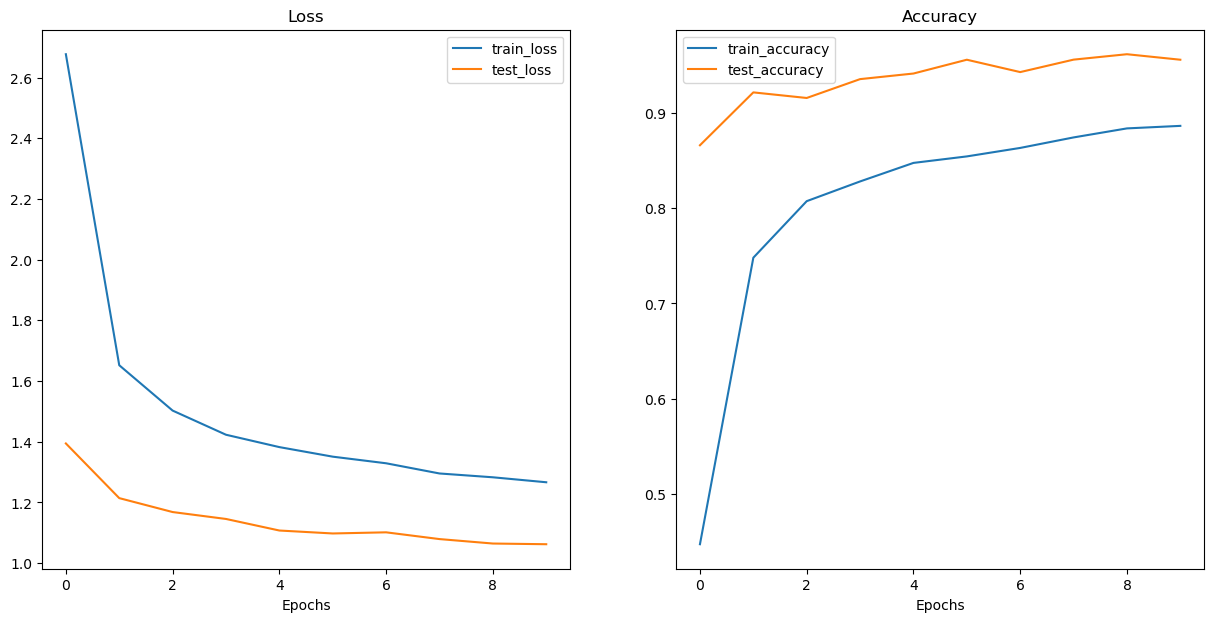

In [92]:
from utils.helper_functions import plot_loss_curves

plot_loss_curves(model_0_results)

## Let's experiment with Efficient Net B0

In [95]:
from utils.helper_functions import set_seeds

# pretrained ResNet18
effnet_weights =  torchvision.models.EfficientNet_B0_Weights.DEFAULT
effnet_auto_transform = effnet_weights.transforms()
effnet_auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [84]:
train_loader, test_loader , class_names = create_dataloaders(train_dir=train_dir,
                                                            test_dir=test_dir,
                                                            train_transform=effnet_auto_transform,
                                                            test_transform=effnet_auto_transform,
                                                            batch_size=args['batch_size'],
                                                            num_workers=args['num_workers'])

In [85]:
model_1 = torchvision.models.efficientnet_b0(weights=effnet_weights).to(device)

for param in model_1.parameters():
    param.requires_grad = False

set_seeds(42)

# Add a new classifier
model_1.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1280, out_features=args['num_classes'])).to(device)

In [86]:
from utils import engine
from utils.early_stopback import EarlyStopback

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# create early stopper
early_stopper = EarlyStopback(patience=5, min_delta=0.05)

# Train the classifier head of the pretrained ResNet
set_seeds()
model_1_results = engine.train(model=model_1,
                               train_dataloader=train_loader,
                               test_dataloader=test_loader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=args['num_epochs'],
                               device=device,
                               early_stopback=early_stopper,
                               writer=None)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7530 | train_acc: 0.5312 | test_loss: 1.6461 | test_acc: 0.8448
Epoch: 2 | train_loss: 1.6766 | train_acc: 0.7866 | test_loss: 1.3247 | test_acc: 0.8835
Epoch: 3 | train_loss: 1.4714 | train_acc: 0.8330 | test_loss: 1.2507 | test_acc: 0.8919
Epoch: 4 | train_loss: 1.3821 | train_acc: 0.8558 | test_loss: 1.2152 | test_acc: 0.8991
Epoch: 5 | train_loss: 1.3285 | train_acc: 0.8785 | test_loss: 1.1869 | test_acc: 0.9118
Epoch: 6 | train_loss: 1.2850 | train_acc: 0.8916 | test_loss: 1.1829 | test_acc: 0.9088
Epoch: 7 | train_loss: 1.2579 | train_acc: 0.9019 | test_loss: 1.1748 | test_acc: 0.9033
Epoch: 8 | train_loss: 1.2252 | train_acc: 0.9109 | test_loss: 1.1654 | test_acc: 0.9074
Epoch: 9 | train_loss: 1.2067 | train_acc: 0.9180 | test_loss: 1.1580 | test_acc: 0.9089
Epoch: 10 | train_loss: 1.1885 | train_acc: 0.9290 | test_loss: 1.1500 | test_acc: 0.9132


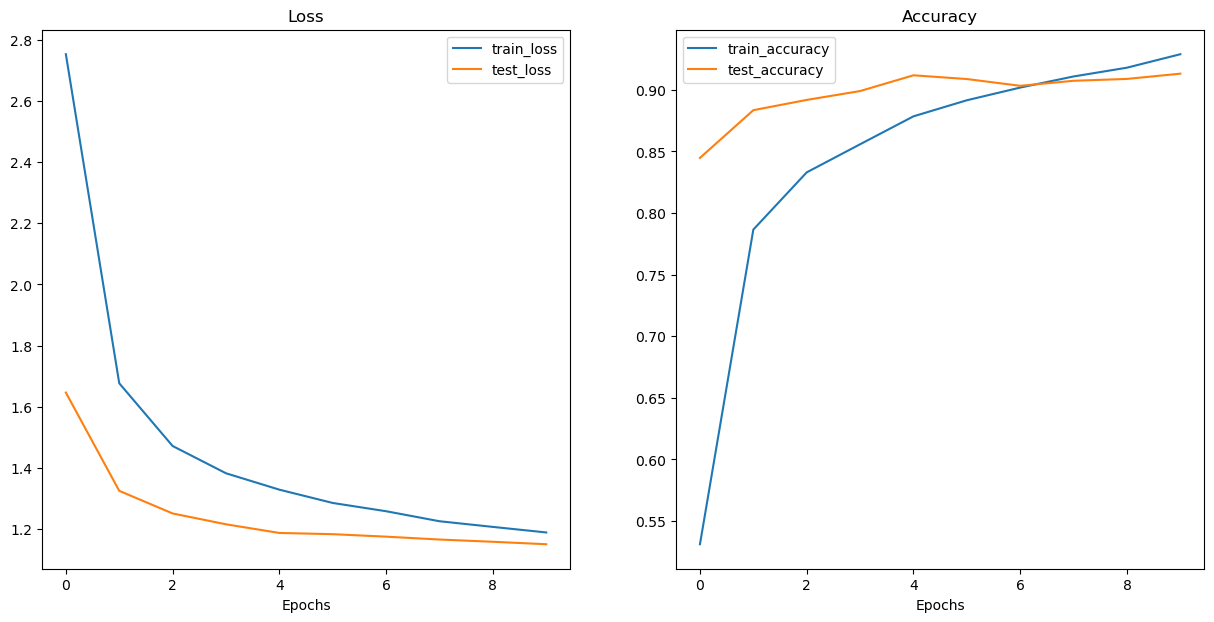

In [99]:
plot_loss_curves(model_1_results)

## Sample Prediction

In [103]:
import requests
from PIL import Image
from typing import List, Tuple

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    img = image_path

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    model.to(device)

    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)


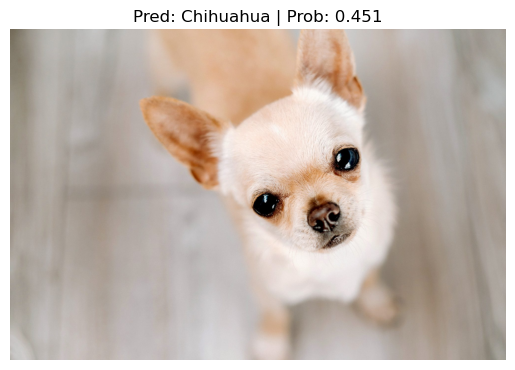

In [118]:
# Test on external URL
url ='https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F47%2F2021%2F03%2F09%2Fchihuahua-light-grey-floor-1900204918-2000.jpg'
image = Image.open(requests.get(url, stream=True).raw)

pred_and_plot_image(model=model_0,
                    class_names=class_names,
                    image_path=image)

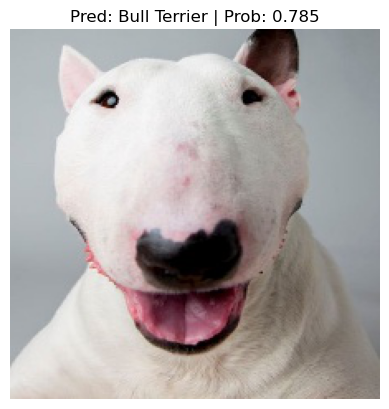

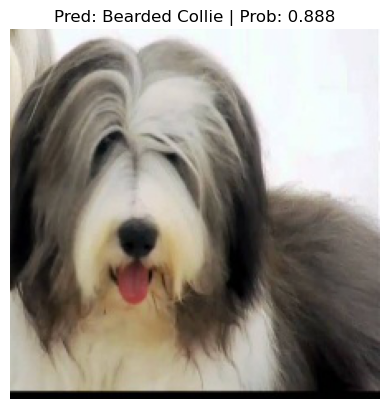

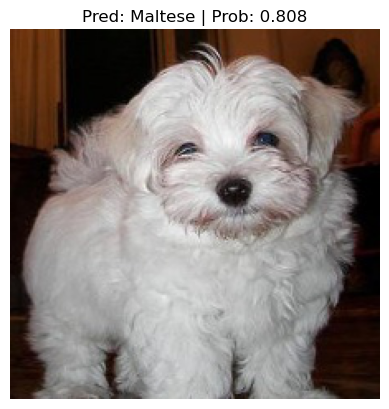

In [117]:
# Get a random list of 3 images
import random
num_images_to_plot = 3
test_image_path_list = list((Path("data/") / "test").glob("*/*.jpg")) # get all test image paths
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model_0,
                        image_path=Image.open(image_path),
                        class_names=class_names,
                        image_size=(224, 224))

## Save model

In [97]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
               
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [98]:
# Create a model path
resnet_model_path = "resnet-dog-breed.pth" 

# Save FoodVision Big model
save_model(model=model_0,
          target_dir="models",
          model_name=resnet_model_path)

# Create a model path
effnet_model_path = "effnet-dog-breed.pth" 

# Save FoodVision Big model
save_model(model=model_1,
          target_dir="models",
          model_name=effnet_model_path)

[INFO] Saving model to: models\resnet-dog-breed.pth
[INFO] Saving model to: models\effnet-dog-breed.pth


In [100]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb0_model_size = (Path("models/") / effnet_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb0_model_size} MB")

pretrained_resnet18_model_size = (Path("models/") / resnet_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_resnet18_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 15 MB
Pretrained EffNetB2 feature extractor model size: 43 MB


Save as ONNX

In [122]:
dummy_input = torch.randn(1, 3, 224, 224, device="cuda")

input_names = ["input1"]
output_names = ["output1"]

torch.onnx.export(
  model_0, 
  dummy_input, 
  "models/resnet_dog_breed.onnx", 
  verbose=True, 
  input_names=input_names,
  output_names=output_names
)

torch.onnx.export(
  model_1, 
  dummy_input, 
  "models/effnet_dog_breed.onnx", 
  verbose=True, 
  input_names=input_names,
  output_names=output_names
)